In [1]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

70. 単語ベクトルの和による特徴量  
    問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例$x_i$の特徴ベクトル$xi$を並べた行列$X$と，正解ラベルを並べた行列（ベクトル）$Y$を作成したい．  
    $$
    X=
    \begin{pmatrix}
    x_1 \\
    x_2 \\
    \cdots \\
    x_n
    \end{pmatrix}
    \in \mathbb{R}^{n \times d}, Y=
    \begin{pmatrix}
    y_1 \\
    y_2 \\
    \cdots \\
    y_n
    \end{pmatrix}
    \in \mathbb{N}^n
    $$  
    ここで，$n$は学習データの事例数であり，$x_i \in \mathbb{R}^d$と$y_i \in \mathbb{N}$はそれぞれ，$i \in \{1, \dots, n\}$番目の事例の特徴量ベクトルと正解ラベルを表す． なお，今回は「ビジネス」「科学技術」「エンターテイメント」「健康」の4カテゴリ分類である．$\mathbb{N}_{<4}$で4未満の自然数（0を含む）を表すことにすれば，任意の事例の正解ラベル$y_i$は$y_i \in \mathbb{N}_{<4}$で表現できる． 以降では，ラベルの種類数を$L$で表す（今回の分類タスクでは$L=4$である）．  
    $i$番目の事例の特徴ベクトル$x_i$は，次式で求める．  
    $$
    x_i = \frac{1}{T_i} \Sigma^{T_i}_{t=1} emb(w_{i,t})
    $$
    ここで，$i$番目の事例は$T_i$個の（記事見出しの）単語列$(w_{i,1},w_{i,2},\dots,w_{i,T_i})$から構成され，$emb(w) \in \mathbb{R}^d$は単語$w$に対応する単語ベクトル（次元数は$d$）である．すなわち，$i$番目の事例の記事見出しを，その見出しに含まれる単語のベクトルの平均で表現したものが$x_i$である．今回は単語ベクトルとして，問題60でダウンロードしたものを用いればよい．300次元の単語ベクトルを用いたので，$d=300$である．  
    $i$番目の事例のラベル$y_i$は，次のように定義する．
    $$
    y_i=
    \left\{
    \begin{array}{ll}
    0 & (記事x_iが「ビジネス」カテゴリの場合) \\
    1 & (記事x_iが「科学技術」カテゴリの場合) \\
    2 & (記事x_iが「エンターテイメント」カテゴリの場合) \\
    3 & (記事x_iが「健康」カテゴリの場合)
    \end{array}
    \right.
    $$
    なお，カテゴリ名とラベルの番号が一対一で対応付いていれば，上式の通りの対応付けでなくてもよい．  
    以上の仕様に基づき，以下の行列・ベクトルを作成し，ファイルに保存せよ．  
    - 学習データの特徴量行列: $X_{train} \in \mathbb{R}^{N_t \times d}$
    - 学習データのラベルベクトル: $Y_{train} \in \mathbb{N}^{N_t}$
    - 検証データの特徴量行列: $X_{valid} \in \mathbb{R}^{N_v \times d}$
    - 検証データのラベルベクトル: $Y_{valid} \in \mathbb{N}^{N_v}$
    - 評価データの特徴量行列: $X_{test} \in \mathbb{R}^{N_e \times d}$
    - 評価データのラベルベクトル: $Y_{test} \in \mathbb{N}^{N_e}$  
      
    なお，$N_t,N_v,N_e$はそれぞれ，学習データの事例数，検証データの事例数，評価データの事例数である．

In [ ]:
wvs = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
def preprocess(text) -> str:
    import texthero as hero
    clean_text = hero.clean(text, pipeline=[
        hero.preprocessing.fillna, 
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits, 
        hero.preprocessing.remove_punctuation, 
        hero.preprocessing.remove_diacritics, 
        hero.preprocessing.remove_stopwords
    ])
    return clean_text

In [ ]:
def calc_vec(s):
    sumvec = np.zeros(300)
    words = s.split()
    for w in words:
        try:
            sumvec += wvs.get_vector(w)
        except KeyError: continue
    return sumvec/len(words)

In [ ]:
for name in ['train','valid','test']:
    df = pd.read_table(name+'.txt', header=0, names=['CATEGORY', 'TITLE'])
    clean_title = preprocess(df['TITLE'])
    X = clean_title.apply(calc_vec)
    X = np.array([X.values[i] for i in range(len(X.values))])
    Y = df['CATEGORY'].replace({'b':0, 't':1, 'e':2, 'm':3})
    np.save(name+'.X', X)
    np.save(name+'.Y', Y.values)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.backend import gradients

71. 単層ニューラルネットワークによる予測  
    問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．
    $$
    \hat{y_1} = softmax(x_1 W), \\
    \hat{Y} = softmax(X_{[1:4]}W)
    $$
    ただし，softmaxはソフトマックス関数，$X_{[1:4]} \in \mathbb{R}^{4 \times d}$は特徴ベクトル$x_1,x_2,x_3,x_4$を縦に並べた行列である．
    $$
    X_{[1:4]}=
    \begin{pmatrix}
    x_1 \\
    x_2 \\
    x_3 \\
    x_4
    \end{pmatrix}
    $$
    行列$W \in \mathbb{R}^{d \times L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．なお，$\hat{y_1} \in \mathbb{R}^{L}$は未学習の行列$W$で事例$x_1$を分類したときに，各カテゴリに属する確率を表すベクトルである． 同様に，$\hat{Y} \in \mathbb{R}^{n \times L}$は，学習データの事例$x_1,x_2,x_3,x_4$について，各カテゴリに属する確率を行列として表現している．

In [3]:
train_X = np.load('train.X.npy', allow_pickle=True)
label = np.load('train.Y.npy', allow_pickle=True)
train_Y = np.identity(4)[label]

valid_X = np.load('valid.X.npy', allow_pickle=True)
label = np.load('valid.Y.npy', allow_pickle=True)
valid_Y = np.identity(4)[label]

test_X = np.load('valid.X.npy', allow_pickle=True)
label = np.load('valid.Y.npy', allow_pickle=True)
test_Y = np.identity(4)[label]

In [5]:
model = Sequential([
    Input(shape=300, name='input_layer'),
    Dense(4, activation='sigmoid', name='dense_layer')
])
model.compile(optimizer='sgd', loss='softmax', metrics=['accuracy'])

In [6]:
model.predict(train_X[:1])

array([[0.48678702, 0.49742734, 0.4794861 , 0.4472388 ]], dtype=float32)

In [7]:
model.predict(train_X[:4])

array([[0.48678702, 0.49742734, 0.47948614, 0.4472388 ],
       [0.49579448, 0.5144602 , 0.48260877, 0.48576888],
       [0.4953651 , 0.558468  , 0.46711385, 0.47748893],
       [0.48919407, 0.5039474 , 0.53616875, 0.49512303]], dtype=float32)

72. 損失と勾配の計算  
    学習データの事例$x_1$と事例集合$x_1,x_2,x_3,x_4$に対して，クロスエントロピー損失と，行列$W$に対する勾配を計算せよ．なお，ある事例$x_i$に対して損失は次式で計算される．  
    $$l_i=−log[事例x_iがy_iに分類される確率]$$  
    ただし，事例集合に対するクロスエントロピー損失は，その集合に含まれる各事例の損失の平均とする．

In [11]:
model = Sequential([
    Input(shape=300, name='input_layer'),
    Dense(4, activation='sigmoid', name='dense_layer')
])
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
loss, acc = model.evaluate(train_X[:4], train_Y[:4])
print('loss :', loss)

1/1 [==============================] - 0s 360ms/step - loss: 1.3767 - accuracy: 0.2500
loss : 1.3767322301864624


In [22]:
tensor_x = tf.convert_to_tensor(train_X[:4])
tensor_y = tf.convert_to_tensor(train_Y[:4])
with tf.GradientTape() as tape:
    tape.watch(tensor_x)
    loss, acc = model.evaluate(tensor_x, tensor_y)
    loss = tf.convert_to_tensor(loss)
grads = tape.gradient(loss, model.trainable_weights)
print(grads)

1/1 [==============================] - 0s 110ms/step - loss: 1.3767 - accuracy: 0.2500
[None, None]


73. 確率的勾配降下法による学習  
    確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列$W$を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

76. チェックポイント
    問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [8]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint/',
    save_weights_only=False,
    monitor='val_accuracy',
    save_best_only=True
)

In [293]:
his = model.fit(train_X, train_Y, epochs=150, \
    validation_data=(test_X,test_Y), callbacks=[model_checkpoint_callback])

Train on 10672 samples, validate on 1334 samples
Epoch 1/150
10672/10672 [==============================] - 2s 179us/sample - loss: 1.2099 - accuracy: 0.6145 - val_loss: 1.0855 - val_accuracy: 0.7339
Epoch 2/150
10672/10672 [==============================] - 2s 171us/sample - loss: 1.0332 - accuracy: 0.7496 - val_loss: 0.9819 - val_accuracy: 0.7564
Epoch 3/150
10672/10672 [==============================] - 1s 129us/sample - loss: 0.9541 - accuracy: 0.7620 - val_loss: 0.9183 - val_accuracy: 0.7594
Epoch 4/150
10672/10672 [==============================] - 1s 125us/sample - loss: 0.8998 - accuracy: 0.7661 - val_loss: 0.8709 - val_accuracy: 0.7616
Epoch 5/150
10672/10672 [==============================] - 1s 100us/sample - loss: 0.8577 - accuracy: 0.7672 - val_loss: 0.8331 - val_accuracy: 0.7624
Epoch 6/150
10672/10672 [==============================] - 1s 129us/sample - loss: 0.8234 - accuracy: 0.7686 - val_loss: 0.8016 - val_accuracy: 0.7661
Epoch 7/150
10672/10672 [====================

74. 正解率の計測  
    問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [294]:
loss, acc = model.evaluate(train_X, train_Y)
print('accuraccy :', acc)

accuraccy : 0.87640554


In [295]:
loss, acc = model.evaluate(valid_X, valid_Y)
print('accuraccy :', acc)

accuraccy : 0.8785607


75. 損失と正解率のプロット  
    問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

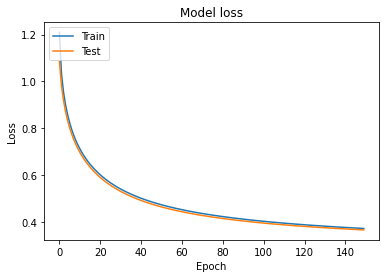

In [296]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

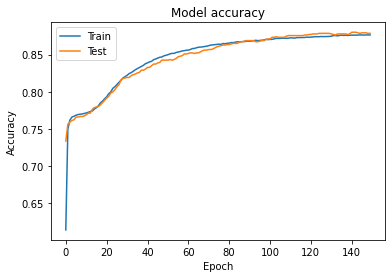

In [297]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

77. ミニバッチ化  
    問題76のコードを改変し，$B$事例ごとに損失・勾配を計算し，行列$W$の値を更新せよ（ミニバッチ化）．$B$の値を$1,2,4,8, \dots$と変化させながら，1エポックの学習に要する時間を比較せよ．

In [9]:
for i in range(6):
    n_batch = 2**i
    print('Batch Size :', n_batch)
    model.fit(train_X, train_Y, batch_size=n_batch, epochs=1, validation_data=(test_X,test_Y))

Batch Size : 1
10672/10672 [==============================] - 32s 3ms/step - loss: 0.4291 - accuracy: 0.8609 - val_loss: 0.4018 - val_accuracy: 0.8703
Batch Size : 2
5336/5336 [==============================] - 38s 7ms/step - loss: 0.4027 - accuracy: 0.8707 - val_loss: 0.3884 - val_accuracy: 0.8711
Batch Size : 4
2668/2668 [==============================] - 14s 5ms/step - loss: 0.3927 - accuracy: 0.8721 - val_loss: 0.3825 - val_accuracy: 0.8733
Batch Size : 8
1334/1334 [==============================] - 6s 5ms/step - loss: 0.3884 - accuracy: 0.8731 - val_loss: 0.3800 - val_accuracy: 0.8733
Batch Size : 16
667/667 [==============================] - 3s 5ms/step - loss: 0.3863 - accuracy: 0.8743 - val_loss: 0.3789 - val_accuracy: 0.8726
Batch Size : 32
334/334 [==============================] - 2s 5ms/step - loss: 0.3853 - accuracy: 0.8742 - val_loss: 0.3783 - val_accuracy: 0.8726


78. GPU上での学習  
    問題77のコードを改変し，GPU上で学習を実行せよ．

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/CPU:0'):
    his = model.fit(train_X, train_Y, epochs=150, \
        validation_data=(test_X,test_Y), callbacks=[model_checkpoint_callback])

79. 多層ニューラルネットワーク
    問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [15]:
multiLayer = Sequential([
    Input(shape=300, name='input_layer'),
    Dense(75, activation='sigmoid', name='dense_layer1'),
    Dense(4, activation='sigmoid', name='dense_layer2')
])

multiLayer.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

multiLayer.fit(train_X, train_Y, epochs=150, validation_data=(test_X,test_Y))

Epoch 1/150
334/334 [==============================] - 2s 4ms/step - loss: 1.1810 - accuracy: 0.4457 - val_loss: 1.1503 - val_accuracy: 0.4280
Epoch 2/150
334/334 [==============================] - 1s 4ms/step - loss: 1.1436 - accuracy: 0.5522 - val_loss: 1.1355 - val_accuracy: 0.4565
Epoch 3/150
334/334 [==============================] - 1s 4ms/step - loss: 1.1280 - accuracy: 0.6142 - val_loss: 1.1182 - val_accuracy: 0.7399
Epoch 4/150
334/334 [==============================] - 1s 4ms/step - loss: 1.1101 - accuracy: 0.6765 - val_loss: 1.0993 - val_accuracy: 0.7406
Epoch 5/150
334/334 [==============================] - 1s 4ms/step - loss: 1.0901 - accuracy: 0.7179 - val_loss: 1.0776 - val_accuracy: 0.7241
Epoch 6/150
334/334 [==============================] - 1s 4ms/step - loss: 1.0667 - accuracy: 0.7312 - val_loss: 1.0526 - val_accuracy: 0.7294
Epoch 7/150
334/334 [==============================] - 1s 3ms/step - loss: 1.0405 - accuracy: 0.7482 - val_loss: 1.0245 - val_accuracy: 0.7519